In [1]:
import sys
sys.path.append('/data_nfs/og86asub/GRN-FinDeR/')

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from arboreto.algo import grnboost2_fdr, grnboost2, diy, genie3
import numpy as np
import scanpy as sc
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import numpy as np


import pingouin


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
def preprocess_data(gex_data):
    gex_data = gex_data.T
    var=pd.DataFrame(gex_data.columns.T)
    var = var.set_index('gene')
    obs = pd.DataFrame(gex_data.index)
    ad = sc.AnnData(gex_data.values, var=var, obs = obs)
    sc.pp.scale(ad)
    new_d = pd.DataFrame(ad.X, columns=gex_data.columns)

    return(new_d)

In [4]:
def compute_nets(new_d, tfs):

        #compute input GRN
        orig_net = grnboost2(expression_data=new_d, tf_names=tfs)
        # Run approximate FDR control.
        fdr_net = grnboost2_fdr(
                tf_names= tfs,
                expression_data=new_d,
                cluster_representative_mode="random",
                num_target_clusters=10,
                num_tf_clusters=-1,
                input_grn=orig_net,
                num_permutations= 1000,
                scale_for_tf_sampling=True)


        fdr_net['p_corrected'] = fdr_net['pvalue']*((fdr_net.shuffled_occurences.max()+1)/fdr_net['shuffled_occurences']+1)
        fdr_net['p_corrected_adj'] =  fdrcorrection(fdr_net['p_corrected'])[1]

        fdr_net['p_corrected'] = fdr_net['pvalue']*((fdr_net.shuffled_occurences.max()+1)/fdr_net['shuffled_occurences']+1)
        fdr_net['p_corrected_adj'] =  fdrcorrection(fdr_net['p_corrected'])[1]
        return orig_net, fdr_net
                


In [51]:



def compute_precision(ranked_df: pd.DataFrame, thresholds: List[int], ground_truth_set: set) -> pd.DataFrame:
    results = []
    #thresholds = [ranked_df.shape[0]]+thresholds
    #i = 0
    #while i< len(thresholds) and thresholds[i]<= ranked_df.shape[0]:
    #    n = thresholds[i]
    for n in thresholds:
        top_n = ranked_df.head(n)
        true_positives = sum(
            tuple(sorted((row['TF'], row['target']))) in ground_truth_set
            for _, row in top_n.iterrows()
        )
        precision = true_positives / top_n.shape[0] if n > 0 else 0
        results.append({'Top N Predictions': n, 'True Positives': true_positives, 'Precision': precision})
        #i = i+1
    return pd.DataFrame(results)



def compute_metrics(orig_net, fdr_net, groundtruth, data_trial = 'data'):

    ground_truth_set = set()
    for _, row in groundtruth.iterrows():
        ground_truth_set.add(tuple(sorted((row['source'], row['target']))))

    results = []

    net_thresh = fdr_net[fdr_net['pvalue'] < 0.01].reset_index(drop=True)


    ranked_fdr_grn = net_thresh.sort_values(by='importance', ascending=False)

    rank_corrected = net_thresh[net_thresh['p_corrected'] < 0.01].reset_index(drop=True)

    rank_corrected_bh = fdr_net[fdr_net['p_corrected_adj'] < 0.01].reset_index(drop=True)

    ranked_network2 = orig_net.sort_values(by='importance', ascending=False)


    thresholds: List[int] = [5, 10, 15, 20, 50, 75, 100, 125, 300, 500]
    thresholds = list(np.sort(thresholds))
    print(thresholds)


    if ranked_fdr_grn.shape[0]>0:
        precision_fdr_grn = compute_precision(ranked_fdr_grn, thresholds, ground_truth_set)
        precision_fdr_grn['comparison'] = 'p_0.05'
        results.append(precision_fdr_grn)

    if rank_corrected.shape[0]>0:
        precision_corrected = compute_precision(rank_corrected, thresholds, ground_truth_set)
        precision_corrected['comparison'] = 'p_corrected_0.05'
        results.append(precision_corrected)
        
   

    if rank_corrected_bh.shape[0]>0:
        precision_corrected_bh = compute_precision(rank_corrected_bh, thresholds, ground_truth_set)
        precision_corrected_bh['comparison'] = 'p_corrected_bh_0.05'
        results.append(precision_corrected_bh)

    if ranked_network2.shape[0]>0:
        precision_network2 = compute_precision(ranked_network2, thresholds, ground_truth_set)
        precision_network2['comparison'] = 'unfiltered'
        results.append(precision_network2)


    precision_all = pd.concat(results)

    precision_all['dataset'] = data_trial
    return precision_all


In [ ]:
metrics_collector =  []
for s in ['5_sources', '10_sources', '20_sources']:
    for i in range(1, 11):
        # Load expression matrix - in this case simulate one.
        gex_data = pd.read_csv(f'/data/bionets/og86asub/GRN-FinDeR/data/sc_simulated_data/{s}/data/data_{i}.tsv', index_col=0, sep='\t')
        groundtruth = pd.read_csv(f'/data/bionets/og86asub/GRN-FinDeR/data/sc_simulated_data/{s}/nets/network_{i}.tsv',  sep='\t')

        tfs = list(groundtruth.source.unique())
        len(tfs)


        targets = list(groundtruth.target.unique())
        len(targets)

        prepr_data = preprocess_data(gex_data)
        orig_net, fdr_net = compute_nets(prepr_data, tfs)

        metrics = compute_metrics(orig_net, fdr_net, groundtruth, data_trial = f'data_{i}')
        metrics['data_configuration'] = s
        metrics_collector.append(metrics)

/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/data/bionets/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packag

[5, 10, 15, 20, 50, 75, 100, 125, 300, 500]


In [53]:
metrics = pd.concat(metrics_collector)

In [54]:
metrics


,Top N Predictions,True Positives,Precision,comparison,dataset
0,5,2,0.400,p_0.05,data_1
1,10,2,0.200,p_0.05,data_1
2,15,2,0.133,p_0.05,data_1
3,20,2,0.100,p_0.05,data_1
4,50,11,0.220,p_0.05,data_1
...,...,...,...,...,...
5,75,19,0.253,unfiltered,data_10
6,100,21,0.210,unfiltered,data_10
7,125,27,0.216,unfiltered,data_10
8,300,43,0.143,unfiltered,data_10


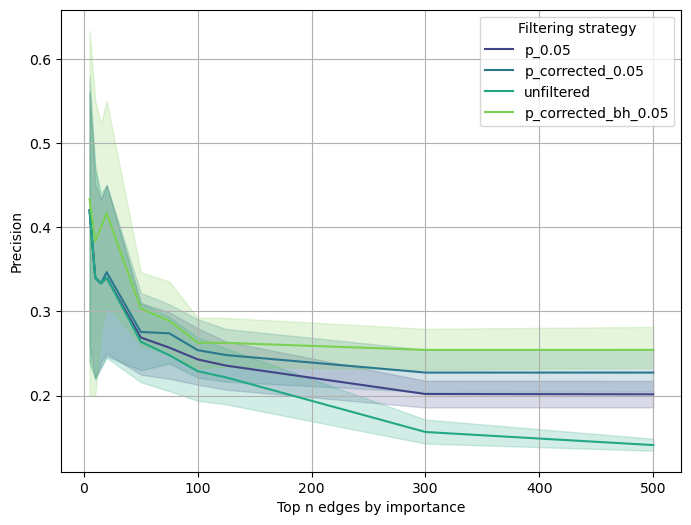

In [55]:
# 2. Seaborn code to plot x vs. y colored by z
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=metrics,
    x='Top N Predictions',
    y='Precision',
    hue='comparison',  # This parameter colors the points based on the 'z' column
    palette='viridis',  # Optional: Choose a color palette
)

plt.xlabel('Top n edges by importance')
plt.ylabel('Precision')
plt.legend(title='Filtering strategy')
plt.grid(True)
plt.show()